Ok, so we now have three different vanishing points. Using these, let's try and use them to gain some insights into the camera's relationship with the scene.

In this post, I will focus on determining the camera's rotation with respect to the scene, using three orthogonal vanishing points present in the scene.

:::{.callout-note}

Hartley & Zisserman put it best, "Vanishing points are images of points at infinity, and provide orientation (attitude) in- formation in a similar manner to that provided by the fixed stars."

:::

[This](https://www.coursera.org/lecture/robotics-perception/vanishing-points-how-to-compute-camera-orientation-flqF4) is a great video to watch for another perspective on this problem.

Ok, now let's import some valuable libraries and visualise the scene.

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=3)

plt.rcParams['figure.figsize'] = [15, 15]

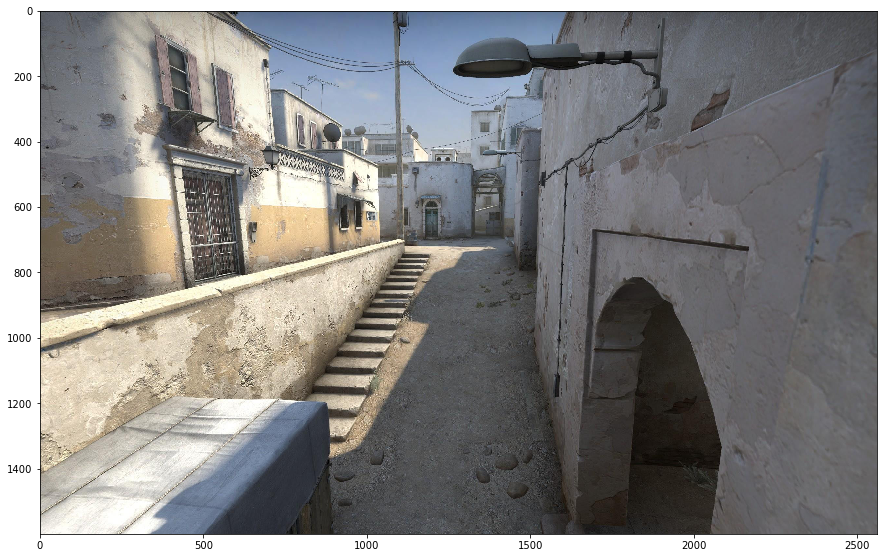

In [2]:
img = Image.open('data/2020-04-10-Finding-Vanishing-Points/csgo-dust2-mid.jpeg')
plt.imshow(img)
plt.show()

Now is an excellent time to pause and talk about homogeneous coordinates.

Let's assume we are comfortable with the Euclidean coordinate system (X,Y,Z). Let's pretend that we have a point, $p$ at:

* $X = 5$
* $Y = 7$
* $Z = 4$

I.E. 

$p = \begin{bmatrix}
5\\
7\\
4
\end{bmatrix}$

Let's go out on a limb. Let's take $p$, and multiply each component by some amount ($k$). In addition, let's append $k$ as an extra dimension.

$p = \begin{bmatrix}
5k\\
7k\\
4k\\
k
\end{bmatrix}$

This is the homogeneous representation of $p$.


Let's now take a point on the $Z$ axis, perhaps $Z=1$ for example:


$p = \begin{bmatrix}
0\\
0\\
1
\end{bmatrix}$

or 

$p = \begin{bmatrix}
0k\\
0k\\
1k\\
k
\end{bmatrix}$

or 

If k is 0 and $Z$ is any other positive value (apart from 0), then it will be a point infinitely far away on the Z-axis. This is also the Z vanishing point. 

$p = \begin{bmatrix}
0\\
0\\
1\\
0
\end{bmatrix}$


From my [other post](https://cgcooke.github.io/Blog/computer%20vision/linear%20algebra/monte%20carlo%20simulation/2020/04/10/Finding-Vanishing-Points.html), we can see that we can map from the points in 3D space ($X$) to points in 2D space ($x$) using the matrix $P$.


\begin{equation*}
x = PX
\end{equation*}

The matrix $P$, in turn, consists of 3 parts. 
1. A intrinsic camera matrix $K$
2. A Rotation matrix $R$
3. A translation matrix $t$


\begin{equation*}
P = K[R | t]
\end{equation*}



Assuming that the camera is free from radial distortion, the Z vanishing point can be found as follows. 



$v_z = K\begin{bmatrix}
R_1 & R_2 & R_3 & | & t 
\end{bmatrix}\begin{bmatrix}
0\\
0\\
1\\
0
\end{bmatrix}
$

We realise that we can knock out everything but the column $R_3$ of the rotation matrix $R$. 

In the [previous post](https://cgcooke.github.io/Blog/computer%20vision/linear%20algebra/2020/04/11/K-From-Vanishing-Points.html), we already found the matrix $K$.

$K  = \begin{bmatrix}
728 & 0 & 1327\\
0 & 728 & 706\\
0 & 0 & 1
\end{bmatrix}$

Now, we can find $R_3$ as follows: 

$R_3 = \frac{K^{-1} v_z}{|K^{-1} v_z|} $

Let's put this into practice.

Now, let's make some assumptions.

1. World X axis pointing right (Red arrow)
2. World Y axis pointing into the scene (Green arrow)
3. World Z axis pointing up (Blue arrow)



![Diagram of a pinhole camera](../images/2020-04-12-R-From-Vanishing-Points/Axis.jpg)


![Diagram of a pinhole camera](../images/2020-04-12-R-From-Vanishing-Points/ImageCoordinateSystem.jpg)





![Diagram of a pinhole camera](../images/2020-02-23-An-Adventure-In-Camera-Calibration/pinholeCamera.png)


In [3]:
vanishing_points = {'VP1': [1371.892, 630.421],
                    'VP2': [-10651.54, 536.681],
                    'VP3': [1272.225, 7683.02 ]}

K = np.array([[7.276e+02,0.000e+00,1.327e+03],
              [6.236e-14,7.276e+02,7.060e+02],
              [1.218e-16,0.000e+00,1.000e+00]])

def make_homogeneous(x):
    x_homogeneous = np.array([x[0],x[1],1])
    return(x_homogeneous)

v_x_h = make_homogeneous(vanishing_points['VP2']) 
v_y_h = make_homogeneous(vanishing_points['VP1'])
v_z_h = make_homogeneous(vanishing_points['VP3'])



K_inv = np.linalg.inv(K)

R_2 = np.dot(K_inv,v_y_h)/np.linalg.norm(np.dot(K_inv,v_y_h)).T
R_3 = -1 * np.dot(K_inv,v_z_h)/np.linalg.norm(np.dot(K_inv,v_z_h)).T
R_1 = np.cross(R_2,R_3) 

R = np.vstack([R_1,R_2,R_3])

print(R)

[[ 0.998  0.014 -0.06 ]
 [ 0.061 -0.103  0.993]
 [ 0.008 -0.995 -0.104]]


This correlates well with what we were expecting. The rotation matrix takes us from the world coordinate system to the camera's coordinate system. In particular, we can see that the matrix $R$ maps (approximately):

1. World X-axis to Camera X-axis
2. World Y-axis to Camera Negative Z-axis
3. World Z-axis to Camera Y-axis


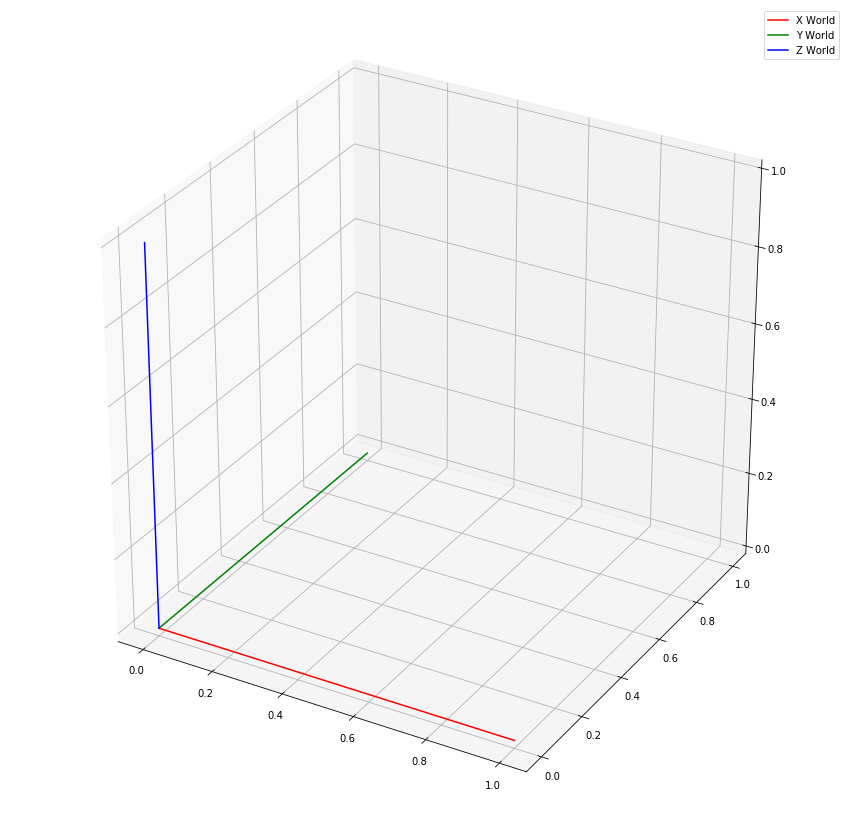

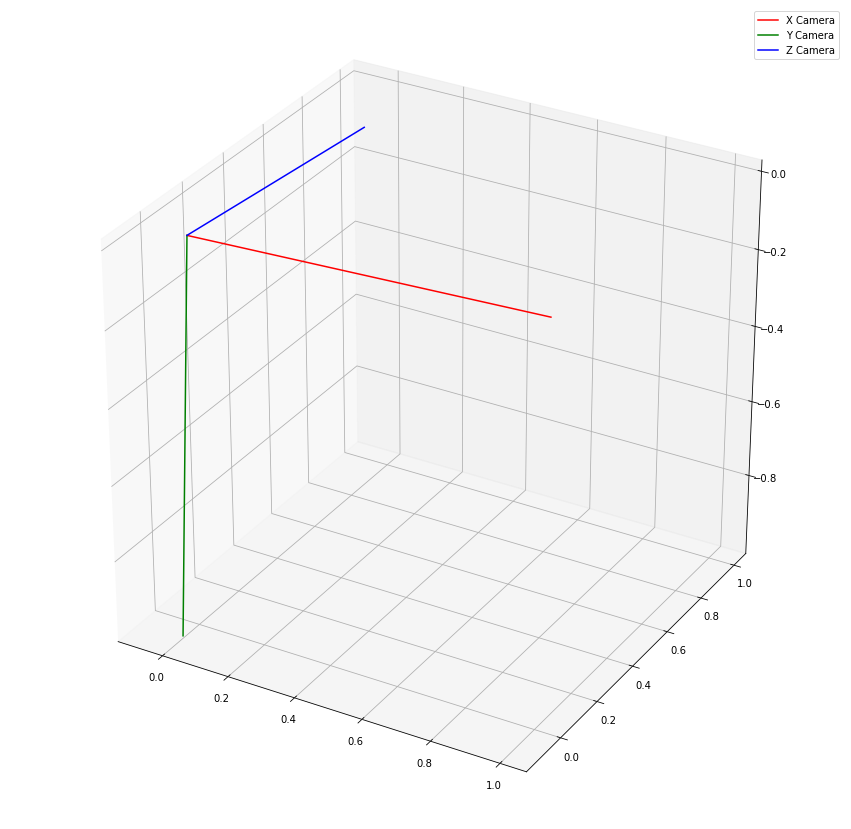

In [4]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.plot(xs=[0,1], ys=[0,0], zs = [0,0],color='r',label='X World')
ax.plot(xs=[0,0], ys=[0,1], zs = [0,0],color='g',label='Y World')
ax.plot(xs=[0,0], ys=[0,0], zs = [0,1],color='b',label='Z World')
plt.legend()
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(xs=[0,R[0,0]], ys=[0,R[1,0]], zs = [0,R[2,0]],color='r',label='X Camera')
ax.plot(xs=[0,R[0,1]], ys=[0,R[1,1]], zs = [0,R[2,1]],color='g',label='Y Camera')
ax.plot(xs=[0,R[0,2]], ys=[0,R[1,2]], zs = [0,R[2,2]],color='b',label='Z Camera')
plt.legend()
plt.show()